In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import socket

# 设定路径
data_dir = "/root/CV_2_lab1/lab2/processed_data"  # 替换为你的路径
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据集
def load_dataset(pt_path):
    images, labels = torch.load(pt_path)
    return TensorDataset(images, labels)

train_dataset = load_dataset(os.path.join(data_dir, "train_data.pt"))
val_dataset = load_dataset(os.path.join(data_dir, "val_data.pt"))
test_dataset = load_dataset(os.path.join(data_dir, "test_data.pt"))

# 类别数
_, train_labels = torch.load(os.path.join(data_dir, "train_data.pt"))
num_classes = len(set(train_labels.tolist()))
print(f"Number of classes: {num_classes}")


Using device: cpu
Number of classes: 102


In [2]:
# 构建模型
def build_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# 训练函数
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            scheduler.step() if phase == "train" else None

            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, best_acc.item()

# Top-k 评估函数
def evaluate_model(model, dataloader, top_k=5):
    model.eval()
    corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.topk(outputs, top_k, 1, True, True)
            corrects += torch.sum(preds.eq(labels.view(-1, 1))).item()
            total += labels.size(0)

    return corrects / total

print("Done!")
print("Hostname:", socket.gethostname())

Done!
Hostname: iZuf68fgu291f8pkjwzxreZ


In [3]:
# 网格搜索训练
def run_grid_search(train_dataset, val_dataset, test_dataset):
    results = []
    lr_list = [0.001, 0.01]
    bs_list = [32, 64]
    epoch_list = [10, 20]

    for lr in lr_list:
        for bs in bs_list:
            for epochs in epoch_list:
                print(f"\nTraining: lr={lr}, bs={bs}, epochs={epochs}")
                model = build_model(num_classes)

                optimizer = optim.SGD([
                    {"params": model.fc.parameters(), "lr": lr},
                    {"params": [p for n, p in model.named_parameters() if "fc" not in n], "lr": lr / 10}
                ], momentum=0.9)
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
                criterion = nn.CrossEntropyLoss()

                train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=2)
                val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=2)
                test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=2)

                dataloaders = {"train": train_loader, "val": val_loader}
                dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

                model, best_val_acc = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=epochs)
                test_top5_acc = evaluate_model(model, test_loader, top_k=5)

                results.append({
                    "lr": lr,
                    "batch_size": bs,
                    "epochs": epochs,
                    "val_acc": best_val_acc,
                    "test_top5_acc": test_top5_acc
                })
    return results

print("Done!")

Done!



Training: lr=0.001, bs=32, epochs=10
Epoch 1/10
Train Acc: 0.2733
Val Acc: 0.4012
Epoch 2/10
Train Acc: 0.4606
Val Acc: 0.5405
Epoch 3/10
Train Acc: 0.5883
Val Acc: 0.6061
Epoch 4/10
Train Acc: 0.6661
Val Acc: 0.6864
Epoch 5/10
Train Acc: 0.7228
Val Acc: 0.7301
Epoch 6/10
Train Acc: 0.7666
Val Acc: 0.7498
Epoch 7/10
Train Acc: 0.7881
Val Acc: 0.7527
Epoch 8/10
Train Acc: 0.8030
Val Acc: 0.7651
Epoch 9/10
Train Acc: 0.8006
Val Acc: 0.7695
Epoch 10/10
Train Acc: 0.8037
Val Acc: 0.7739

Training: lr=0.001, bs=32, epochs=20
Epoch 1/20
Train Acc: 0.2770
Val Acc: 0.4179
Epoch 2/20
Train Acc: 0.4764
Val Acc: 0.5383
Epoch 3/20
Train Acc: 0.5961
Val Acc: 0.6338
Epoch 4/20
Train Acc: 0.6722
Val Acc: 0.6732
Epoch 5/20
Train Acc: 0.7336
Val Acc: 0.7257
Epoch 6/20
Train Acc: 0.7683
Val Acc: 0.7571
Epoch 7/20
Train Acc: 0.8055
Val Acc: 0.7498
Epoch 8/20
Train Acc: 0.8048
Val Acc: 0.7542
Epoch 9/20
Train Acc: 0.8028
Val Acc: 0.7498
Epoch 10/20
Train Acc: 0.8134
Val Acc: 0.7586
Epoch 11/20
Train Acc:

,lr,batch_size,epochs,val_acc,test_top5_acc
7,0.010,64,20,0.849745,0.981063
5,0.010,32,20,0.859956,0.979607
6,0.010,64,10,0.852662,0.977422
4,0.010,32,10,0.860686,0.976693
1,0.001,32,20,0.767323,0.966497
0,0.001,32,10,0.773888,0.963583
3,0.001,64,20,0.649891,0.926438
2,0.001,64,10,0.638950,0.897305


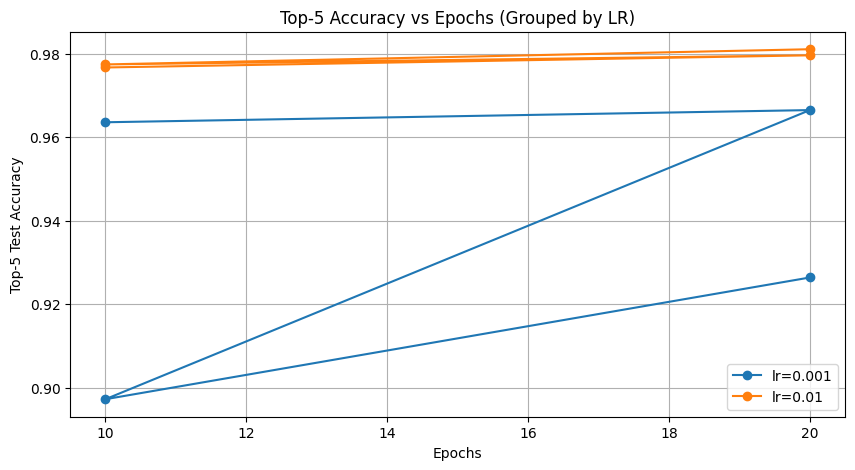

In [4]:
# 保存为 DataFrame 并可视化
def visualize_results(results):
    df = pd.DataFrame(results)
    display(df.sort_values(by="test_top5_acc", ascending=False))

    plt.figure(figsize=(10, 5))
    for lr in df["lr"].unique():
        subset = df[df["lr"] == lr]
        plt.plot(subset["epochs"], subset["test_top5_acc"], marker='o', label=f"lr={lr}")
    plt.xlabel("Epochs")
    plt.ylabel("Top-5 Test Accuracy")
    plt.title("Top-5 Accuracy vs Epochs (Grouped by LR)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df

# 示例调用：
results = run_grid_search(train_dataset, val_dataset, test_dataset)
df_results = visualize_results(results)
